In [31]:
# policy gradient algorithm

import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam

import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

from IPython.display import clear_output

ENV_NAME = 'CartPole-v1'
HIDDEN_SIZES = [256, 256]
STEP_SIZE = 1e-3
EPOCHS = 50
BATCH_SIZE = 5000

def mlp(sizes, activation=nn.Tanh, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1], act())]
    return nn.Sequential(*layers)

env = gym.make(ENV_NAME)
env_ren = gym.make(ENV_NAME, render_mode='rgb_array')
obs_dim = env.observation_space.shape[0]
n_acts = env.action_space.n

logits_net = mlp(sizes=[obs_dim] + HIDDEN_SIZES + [n_acts])

def get_policy(obs):
    logits = logits_net(torch.as_tensor(obs, dtype=torch.float32))
    return Categorical(logits=logits)

def get_action(obs):
    return get_policy(obs).sample().item()

def compute_loss(obs, act, weights):
    logp = get_policy(obs).log_prob(act)
    return -(logp * weights).mean()

optimizer = Adam(logits_net.parameters(), lr=STEP_SIZE)

In [32]:
for i in range(EPOCHS):

    batch_obs = []
    batch_acts = []
    batch_weights = []
    batch_rets = []
    batch_lens = []

    obs, _ = env.reset()
    done = False
    ep_rews = []

    while True:

        batch_obs.append(obs.copy())

        act = get_action(obs)
        obs, rew, done, over, _ = env.step(act)

        batch_acts.append(act)
        ep_rews.append(rew)

        if done or over:

            ep_ret, ep_len = sum(ep_rews), len(ep_rews)
            batch_rets.append(ep_ret)
            batch_lens.append(ep_len)

            batch_weights += [ep_ret] * ep_len

            (obs, _), done, ep_rews = env.reset(), False, []

            if len(batch_obs) > BATCH_SIZE:
                break

    optimizer.zero_grad()

    batch_loss = compute_loss(obs=torch.as_tensor(batch_obs, dtype=torch.float32),
        act=torch.as_tensor(batch_acts, dtype=torch.int32),
        weights=torch.as_tensor(batch_weights, dtype=torch.float32)
    )

    batch_loss.backward()
    optimizer.step()

    print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'% (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))

epoch:   0 	 loss: 22.992 	 return: 25.080 	 ep_len: 25.080
epoch:   1 	 loss: 35.381 	 return: 39.504 	 ep_len: 39.504
epoch:   2 	 loss: 54.375 	 return: 56.000 	 ep_len: 56.000
epoch:   3 	 loss: 58.436 	 return: 70.887 	 ep_len: 70.887
epoch:   4 	 loss: 61.444 	 return: 81.032 	 ep_len: 81.032
epoch:   5 	 loss: 65.498 	 return: 91.321 	 ep_len: 91.321
epoch:   6 	 loss: 146.954 	 return: 186.630 	 ep_len: 186.630
epoch:   7 	 loss: 108.594 	 return: 162.419 	 ep_len: 162.419
epoch:   8 	 loss: 110.502 	 return: 162.548 	 ep_len: 162.548
epoch:   9 	 loss: 162.785 	 return: 215.600 	 ep_len: 215.600
epoch:  10 	 loss: 124.869 	 return: 194.481 	 ep_len: 194.481
epoch:  11 	 loss: 115.860 	 return: 178.786 	 ep_len: 178.786
epoch:  12 	 loss: 124.133 	 return: 185.444 	 ep_len: 185.444
epoch:  13 	 loss: 106.700 	 return: 162.839 	 ep_len: 162.839
epoch:  14 	 loss: 101.222 	 return: 168.677 	 ep_len: 168.677
epoch:  15 	 loss: 108.582 	 return: 178.679 	 ep_len: 178.679
epoch:  16

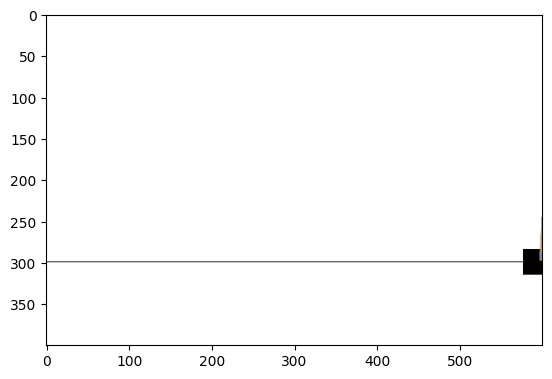

In [33]:
def render(env):
    img = env.render()
    plt.imshow(img)
    plt.show()
    clear_output(wait=True)

obs, _ = env_ren.reset()
done = False

while True:

    act = get_action(obs)
    obs, rew, done, over, _ = env_ren.step(act)

    render(env_ren)
    
    if done or over:
        break